<font size="5">**Project MDI701 : Predicting H-1B application result in the US**</font>
<br><br>
We all know that the American work visa is difficult to obtain, applicants must have luck to get the draw before starting the application process. 
<br>
This project aims to study the H1B - American visa passing rate with different applicants background information such as "wage", "company", "job title" etc.
<br><br>
The project has 6 parts:
<br>
First part: import data
<br>
Second part: study data structure
<br>
Third part: clean data
<br>
Fourth part: analyze data
<br>
Fifth part: use machine learning to predict pass or rejected
<br>
Sixth part: use cross validation to improve the model

In [ ]:
import findspark
import pyspark
import random
import plotly
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.ml.linalg import VectorUDT,Vectors
from pyspark.sql.functions import split 
from pyspark.sql.functions import substring_index 
from pyspark.sql.functions import round
from pyspark.sql.functions import avg
import pyspark.sql.functions as func
from matplotlib import pyplot as plt
import pyspark.sql.functions as f
import numpy as np


sc = pyspark.SparkContext(appName="Pi")
findspark.init()

# Import data

In [2]:

schema = StructType([StructField("No", IntegerType(), True),
                     StructField("CASE_STATUS",StringType(),True),
                     StructField("EMPLOYER_NAME",StringType(),True),
                     StructField("SOC_NAME",StringType(),True),
                     StructField("JOB_TITLE",StringType(),True),
                     StructField("FULL_TIME_POSITION",StringType(),True),
                     StructField("PREVAILING_WAGE",IntegerType(),True),
                     StructField("YEAR",IntegerType(),True),
                     StructField("WORKSITE",StringType(),True),
                     StructField("lon",StringType(),True),
                     StructField("lat",StringType(),True)])

raw_data = SQLContext(sc).read.schema(schema).option('header', 'true').csv('/Users/didi/Documents/Telecom/MDI701/Projet/h1b_kaggle.csv')

#  Data schema

In [4]:
raw_data.printSchema()

root
 |-- No: integer (nullable = true)
 |-- CASE_STATUS: string (nullable = true)
 |-- EMPLOYER_NAME: string (nullable = true)
 |-- SOC_NAME: string (nullable = true)
 |-- JOB_TITLE: string (nullable = true)
 |-- FULL_TIME_POSITION: string (nullable = true)
 |-- PREVAILING_WAGE: integer (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- WORKSITE: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- lat: string (nullable = true)



**The meaning of the columns are as follows:**

**X1** - not named column, it is the id of the row;
<br>
**CASE_STATUS** - status of the application;
<br>
**EMPLOYER_NAME** - the name of the employer as registered in the H-1B Visa application;
<br>
**SOC_NAME** - the occupation code for the employment;
<br>
**JOB_TITLE** - the job title for the employment;
<br>
**FULL_TIME_POSITION** - whether the application is for a full-time position of for a part-time position;
<br>
**PREVAILING_WAGE** - the most frequent wage for the corresponding role as filled in the Visa application;
<br>
**YEAR** - the application year;
<br>
**WORKSITE** - the address of the employer worksite;
<br>
**lon** - longitude of the employer worksite;
<br>
**lat** - latitude of the employer worksite;

# Data cleaning

Identify and remove error data, in order to create a reliable dataset. This improves the quality of the training data and the training model.

In [5]:
#replace the detail address by states because each state has the same law
data = raw_data.withColumn("WORKSITE", split(raw_data['WORKSITE'], ",")[1])

#round the longtitude and altitude
data = data.withColumn("lat", func.round(data["lat"]))
data = data.withColumn("lon", func.round(data["lon"]))

#drop rows with CASE_STATUS null
data = data.filter("CASE_STATUS != 'NA'")

#drop rows with FULL_TIME_POSITION out of range
data = data.filter(data.FULL_TIME_POSITION.isin("Y", "N"))

#ignore wage under 10000 per year which is very probable wrong data
data= data.filter("PREVAILING_WAGE > 10000")

#drop rows with YEAR in the future
data = data.filter("YEAR < '2020'")

# Data Analysis

To exploit and understand the data better.

## Graphical analysis

### Distribution of case status

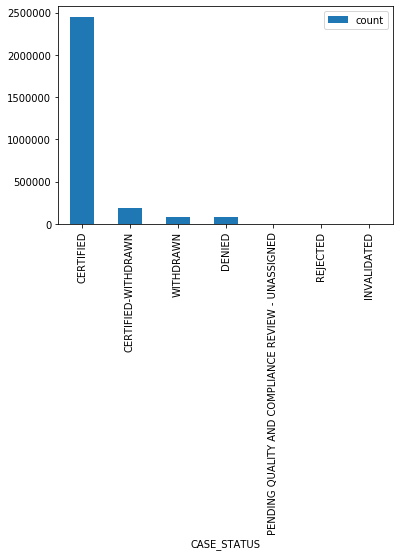

In [6]:
casestatus = data.filter(data.CASE_STATUS.isNotNull()).groupby("CASE_STATUS").count().sort("count", ascending = False)
casestatus = casestatus.toPandas()
casestatus.plot.bar('CASE_STATUS')
plt.show()

### Applications by job titles

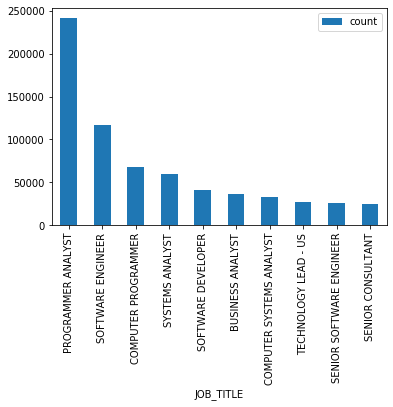

In [7]:
jobtitle = data.select("JOB_TITLE").groupBy("JOB_TITLE").count().sort("count", ascending = False).limit(10)
jobtitle = jobtitle.toPandas()
jobtitle.plot.bar('JOB_TITLE')
plt.show()

### Prevailing wage

We can observe that the average wage is between 60000 and 70000 dollars.


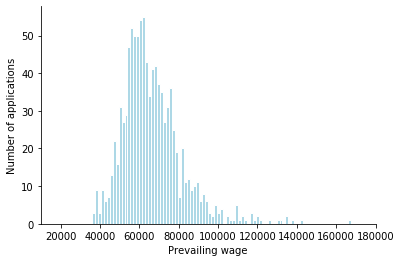

In [30]:
wage = data.select("PREVAILING_WAGE").groupBy("PREVAILING_WAGE").count().sort("count", ascending = False).limit(1000)
wage = wage.toPandas()
p_, ax = plt.subplots()
ax.hist(wage['PREVAILING_WAGE'], bins=100, facecolor='lightblue', edgecolor='w')
ax.set_xlabel("Prevailing wage")
ax.set_ylabel('Number of applications')
plt.xlim([10000, 180000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print("We can observe that the average wage is between 60000 and 70000 dollars.")

### Applications grouped by employer names

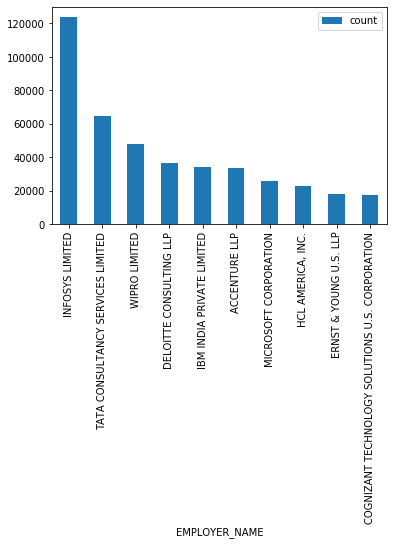

In [9]:
employer = data.select("EMPLOYER_NAME").groupBy("EMPLOYER_NAME").count().sort("count", ascending = False).limit(10)
employer = employer.toPandas()
employer.plot.bar('EMPLOYER_NAME')
plt.show()

## Numerical Analysis

### Wage statistical analysis

In [10]:
print("Statistics for H1-B Visa Applications:\n")
print("Minimum wage: ${:,.2f}".format(min(wage['PREVAILING_WAGE'])))
print("Maximum wage: ${:,.2f}".format(max(wage['PREVAILING_WAGE'])))
print("Mean wage: ${:,.2f}".format(np.mean(wage['PREVAILING_WAGE'])))
print("Median wage ${:,.2f}".format(np.median(wage['PREVAILING_WAGE'])))
print("Standard deviation of wage: ${:,.2f}".format(np.std(wage['PREVAILING_WAGE'])))

Statistics for H1-B Visa Applications:

Minimum wage: $35,838.00
Maximum wage: $187,200.00
Mean wage: $66,651.60
Median wage $63,679.50
Standard deviation of wage: $16,448.64


# Logistic Regression

Logistic Regression is used in the situation where data is in large scale, contains multiple category variables, and label contains 2 values. Which is perfect for our case.

## Modeling

The training model is LogisticRegression. Before fitting, the string data needs to be converted into index, and the numerical data needs to be standarized. If one of the features has a big range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance. The standarization helps also to accelerate the gradient descent.

In [13]:
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScaler

#we consider the status has 2 main categories - certified (label = 1) and not certified (label = 0)
data = data.withColumn("label", F.when(data.CASE_STATUS.isin("CERTIFIED"),1).otherwise(0))

#rearrange columns place in order to facilite indexe
data_lr = data.select("label","CASE_STATUS", "No", "PREVAILING_WAGE", "YEAR", "EMPLOYER_NAME", "SOC_NAME", "JOB_TITLE", "FULL_TIME_POSITION", "WORKSITE")

#split the data by train and test
train, test = data_lr.randomSplit([0.7, 0.3])

#create index for assembled string values
indexer1 = StringIndexer(inputCol = "EMPLOYER_NAME", outputCol = "EMPLOYER_NAME_idx",handleInvalid="keep")
indexer2 = StringIndexer(inputCol = "SOC_NAME", outputCol = "SOC_NAME_idx",handleInvalid='keep')
indexer3 = StringIndexer(inputCol = "JOB_TITLE", outputCol = "JOB_TITLE_idx",handleInvalid='keep')
indexer4 = StringIndexer(inputCol = "FULL_TIME_POSITION", outputCol = "FULL_TIME_POSITION_idx",handleInvalid='keep')
indexer5 = StringIndexer(inputCol = "WORKSITE", outputCol = "WORKSITE_idx",handleInvalid='keep')

#combines categorical features into a single vector
catVect = VectorAssembler(inputCols = ["EMPLOYER_NAME_idx", "SOC_NAME_idx", "JOB_TITLE_idx", "FULL_TIME_POSITION_idx", "WORKSITE_idx"], outputCol="catFeatures")
#creates indexes for a vector of categorical features
catIdx = VectorIndexer(inputCol = catVect.getOutputCol(), outputCol = "idxCatFeatures")

#combines numerical features into a single vector
numVect = VectorAssembler(inputCols = ["PREVAILING_WAGE", "YEAR"], outputCol="numFeatures")
#standardize PREVAILING_WAGE and YEAR for weight input
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol="normFeatures")

#combines categorical and numerical features into final feature
featVect = VectorAssembler(inputCols=["idxCatFeatures", "normFeatures"], outputCol="features")

#initiate logistic regression parametres
lr = LogisticRegression(labelCol="label",featuresCol="features",maxIter=10, regParam=0.3)

#build a pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, catVect, catIdx,numVect,minMax, featVect,lr ])

#train and test the lr model
prediction = pipeline.fit(train).transform(test)
#show predictions and labels
predicted = prediction.select("features", "prediction", "label").show()

+--------------------+----------+-----+
|            features|prediction|label|
+--------------------+----------+-----+
|[59.0,53.0,132.0,...|       1.0|    0|
|[37390.0,194.0,42...|       1.0|    0|
|[7466.0,194.0,130...|       1.0|    0|
|[39826.0,194.0,38...|       1.0|    0|
|[78257.0,194.0,30...|       1.0|    0|
|[82341.0,194.0,30...|       1.0|    0|
|[10858.0,194.0,53...|       1.0|    0|
|[145251.0,194.0,4...|       1.0|    0|
|[36635.0,194.0,37...|       1.0|    0|
|[1651.0,90.0,201....|       1.0|    0|
|[209.0,90.0,2905....|       1.0|    0|
|[113572.0,90.0,21...|       1.0|    0|
|[12713.0,90.0,310...|       1.0|    0|
|[4267.0,90.0,2194...|       1.0|    0|
|[14222.0,90.0,219...|       1.0|    0|
|[148312.0,90.0,70...|       1.0|    0|
|[117617.0,90.0,60...|       1.0|    0|
|[173742.0,90.0,80...|       1.0|    0|
|[175588.0,90.0,43...|       1.0|    0|
|[75571.0,90.0,441...|       1.0|    0|
+--------------------+----------+-----+
only showing top 20 rows



## Result

4 class of label and prediction (true positive, true negative, false positive, false negative). Here we observe that the prediction predicts more label 1 than the reel label. However, this doesn't have much impact on presicion score, because the label 1 is the majority in the dataset. 

In [14]:
prediction.groupBy("label", "prediction").count().show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0|     1|
|    0|       0.0|    62|
|    1|       1.0|735430|
|    0|       1.0|106021|
+-----+----------+------+



In [15]:
tp = float(prediction.filter("prediction == 1.0 AND label == 1").count())
fp = float(prediction.filter("prediction == 1.0 AND label == 0").count())
tn = float(prediction.filter("prediction == 0.0 AND label == 0").count())
fn = float(prediction.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = SQLContext(sc).createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()
print("The precision score is quite good.")

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|          735430.0|
|       FP|          106021.0|
|       TN|              62.0|
|       FN|               1.0|
|Precision|0.8740021700610018|
|   Recall|0.9999986402531305|
|       F1|0.9327647851900142|
+---------+------------------+



## Review the Area Under ROC¶

The ROC (Receiver Operating Characteristic) method can also evaluate the performance of a classification model. 
<br>
Bigger the area under a ROC curve for the model, better the model is.

In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
area = evaluator.evaluate(prediction)
print ("Area under ROC is :", area)
print()

Area under ROC is : 0.573608768952961



# CrossValidation and Hyper Parameter Tuning

CrossValidator helps to find the best parameter combinaisions for the best result. The parameters are segmented in ParameterGrid then inserted into CrossValidator. The parameters take part into the training process which is defined as estimator in the CrossValidator.

## Modeling

In [19]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

grid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5, 10, 15]) \
    .addGrid(lr.regParam, [0.1, 0.3, 0.5]) \
    .build()

#initiate a CrossValidator 
cv = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=grid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=4,
                          parallelism=2)


cvModel = cv.fit(train)
prediction_cv = cvModel.transform(test)
predicted_cv = prediction.select("features", "prediction", "label")

## Results

In [22]:
prediction_cv.groupBy("label", "prediction").count().show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0|     1|
|    0|       0.0|    19|
|    1|       1.0|735430|
|    0|       1.0|106064|
+-----+----------+------+



In [20]:
tp_cv = float(prediction_cv.filter("prediction == 1.0 AND label == 1").count())
fp_cv = float(prediction_cv.filter("prediction == 1.0 AND label == 0").count())
tn_cv = float(prediction_cv.filter("prediction == 0.0 AND label == 0").count())
fn_cv = float(prediction_cv.filter("prediction == 0.0 AND label == 1").count())
pr_cv = tp_cv / (tp_cv + fp_cv)
re_cv = tp_cv / (tp_cv + fn_cv)
metrics_cv = SQLContext(sc).createDataFrame([
 ("TP", tp_cv),
 ("FP", fp_cv),
 ("TN", tn_cv),
 ("FN", fn_cv),
 ("Precision", pr_cv),
 ("Recall", re_cv),
 ("F1", 2*pr_cv*re_cv/(re_cv+pr_cv))],["metric", "value"])
metrics_cv.show()
print("Cross Validation has a better model precision.")

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|          735430.0|
|       FP|          106064.0|
|       TN|              19.0|
|       FN|               1.0|
|Precision|0.8739575089067777|
|   Recall|0.9999986402531305|
|       F1|0.9327393503178655|
+---------+------------------+



## Review the Area of ROC

In [32]:
evaluator_cv = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
area_cv = evaluator_cv.evaluate(prediction_cv)
print( "Area under ROC is :", area_cv)
print("Even the precision score is good, the Area under ROC is not good enough. This might caught by too much data in one class and not enough in the other. So that model tends to predict into the bigger class to have a better performance. However, we can see that this impacts on the ROC performance a lot.")

Area under ROC is : 0.5000888726467617
Even the precision score is good, the Area under ROC is not good enough. This might caught by too much data in one class and not enough in the other. So that model tends to predict into the bigger class to have a better performance. However, we can see that this impacts on the ROC performance a lot.
